In [49]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
batch_size = 32 # how many independent sequences will we process in parallel?
context_length = 8 # what is the maximum context length for predictions?
max_iters = 3000
eval_interval = 300
learning_rate = 1e-3
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

## Punjabi Datasets

In [3]:
import re

def preprocess_punjabi_text(text):
    """Preprocesses Punjabi text by removing/handling non-Punjabi characters.

    Args:
        text (str): The input Punjabi text.

    Returns:
        str: The preprocessed Punjabi text.
    """

    # 1. Remove/Replace Non-Gurmukhi Characters (using regular expressions)
    text = re.sub(r"[^ਁ-ਙਛ-਩ਫ-ਭਰ-਱ਲ-਴ਵ-਷ਸ-਺਻਽-੆ੈ-ੋ੍-੏ੑ-੓੕-ਖ਼\s]", "", text) 
    #  Explanation:
    #   - `[^...]`: Matches any character NOT within the brackets.
    #   - `ਁ-ਙਛ-਩...`: Specifies the Unicode range for Gurmukhi characters.
    #   - `\s`: Matches whitespace characters (spaces, tabs, newlines).

    # 2. Handle Special Cases (optional, based on your data)
    #   - Replace common punctuation with their Punjabi equivalents if needed.
    #   - Normalize whitespace (e.g., multiple spaces to a single space).

    return text

# Example Usage
text = "ਇਹ ਇੱਕ ਪੰਜਾਬੀ ਵਾਕ ਹੈ। (This is a Punjabi sentence.)"
processed_text = preprocess_punjabi_text(text)
print(processed_text)

ਇਹ ਇਕ ਜਾਬੀ ਵਾਕ ਹੈ     


In [4]:
from langdetect import detect

def filter_by_language(text):
    output = []
    for token in text.split():
        try:
            try:
                float(token)
                output.append(token)
            except:
                lang = detect(token)
                if lang == "pa":  # Punjabi language code
                    output.append(token)
        except:
            continue
            #print(token)  # Handle cases where language detection fails
    return ' '.join(output)

text = "This is some English text. ਮੈਂ ਪੰਜਾਬੀ ਬੋਲਦਾ ਹਾਂ। ਸਰਕਾਰ 2011 ਦੇ ਅੰਕੜਿਆ ਉੱਤੇ ਆਧਾਰ ਬਣਾਉਣਾ ਗਲਤ ਹੈ? ਇਸ ਨੂੰ 16 ਕਰੋੜ ਵਿਊਜ਼ ਅਤੇ 1.78 ਕਰੋੜ ਕੁਮੈਂਟਸ ਮਿਲੇ। ਦੂਜੇ ਪਾਸੇ ਹੈਸ਼ਟੈਗ #SichuanAirlinesWindscreenGlassCracked ਨੂੰ 6.8 ਕਰੋੜ ਵਿਊਜ਼ ਅਤੇ 49,000 ਕੁਮੈਂਟਸ ਮਿਲੇ।ਕਈ ਲੋਕਾਂ ਨੇ ਕੈਪਟਨ ਨੂੰ ਇਨਾਮ ਦੇਣ ਦੀ ਮੰਗ ਕੀਤੀ ਤਾਂ ਕਈ ਲੋਕਾਂ ਨੇ ਜਹਾਜ਼ਾਂ ਦੀ ਸੁਰੱਖਿਆ ਨੂੰ ਹੋਰ ਪੁਖ਼ਤਾ ਕੀਤੇ ਜਾਣ ਦੀ ਗੱਲ ਕਹੀ।ਲੇਜ਼ੀ ਪਿੱਗ ਗਰਲ ਨਾਂ ਦੇ ਇੱਕ ਯੂਜ਼ਰ ਨੇ ਸੋਸ਼ਲ ਮੀਡੀਆ 'ਤੇ ਲਿਖਿਆ, ''ਅਜਿਹਾ ਹਾਦਸਾ ਕਿਵੇਂ ਹੋ ਸਕਦਾ ਹੈ? ਇਸ ਘਟਨਾ ਦੀ ਜਾਂਚ ਕਰਕੇ ਜ਼ਿੰਮੇਵਾਰ ਲੋਕਾਂ ਨੂੰ ਸਜ਼ਾ ਦਿੱਤੀ ਜਾਣੀ ਚਾਹੀਦੀ ਹੈ..."
filtered_text = filter_by_language(text)
print(filtered_text)  # Output: "ਮੈਂ ਪੰਜਾਬੀ ਬੋਲਦਾ ਹਾਂ।"

ਮੈਂ ਪੰਜਾਬੀ ਬੋਲਦਾ ਹਾਂ। ਸਰਕਾਰ 2011 ਦੇ ਅੰਕੜਿਆ ਉੱਤੇ ਆਧਾਰ ਬਣਾਉਣਾ ਗਲਤ ਹੈ? ਇਸ ਨੂੰ 16 ਕਰੋੜ ਵਿਊਜ਼ ਅਤੇ 1.78 ਕਰੋੜ ਕੁਮੈਂਟਸ ਮਿਲੇ। ਦੂਜੇ ਪਾਸੇ ਹੈਸ਼ਟੈਗ ਨੂੰ 6.8 ਕਰੋੜ ਵਿਊਜ਼ ਅਤੇ ਕੁਮੈਂਟਸ ਮਿਲੇ।ਕਈ ਲੋਕਾਂ ਨੇ ਕੈਪਟਨ ਨੂੰ ਇਨਾਮ ਦੇਣ ਦੀ ਮੰਗ ਕੀਤੀ ਤਾਂ ਕਈ ਲੋਕਾਂ ਨੇ ਜਹਾਜ਼ਾਂ ਦੀ ਸੁਰੱਖਿਆ ਨੂੰ ਹੋਰ ਪੁਖ਼ਤਾ ਕੀਤੇ ਜਾਣ ਦੀ ਗੱਲ ਕਹੀ।ਲੇਜ਼ੀ ਪਿੱਗ ਗਰਲ ਨਾਂ ਦੇ ਇੱਕ ਯੂਜ਼ਰ ਨੇ ਸੋਸ਼ਲ ਮੀਡੀਆ 'ਤੇ ਲਿਖਿਆ, ''ਅਜਿਹਾ ਹਾਦਸਾ ਕਿਵੇਂ ਹੋ ਸਕਦਾ ਹੈ? ਇਸ ਘਟਨਾ ਦੀ ਜਾਂਚ ਕਰਕੇ ਜ਼ਿੰਮੇਵਾਰ ਲੋਕਾਂ ਨੂੰ ਸਜ਼ਾ ਦਿੱਤੀ ਜਾਣੀ ਚਾਹੀਦੀ ਹੈ...


In [5]:
float('1780')

1780.0

In [6]:
import pandas as pd
df_punj = pd.read_csv('data/train 2.csv')
punj_data_1 = '\n\n'.join(df_punj['article'].tolist())
ind = random.randint(0, len(punj_data_1))
len(punj_data_1.split())
print(punj_data_1[ind:ind+5000])

ੀ ਛੱਡ ਦੇਣਗੇ।     Image Copyright @narendramodi @narendramodi       Image Copyright @narendramodi @narendramodi    ਫਿਲਹਾਲ ਤਾਂ ਜੀਡੀ ਅਗਰਵਾਲ ਇੱਕ ਸੰਨਿਆਸੀ ਦਾ ਜੀਵਨ ਜੀ ਰਹੇ ਸਨ। ਉਨ੍ਹਾਂ ਨੂੰ ਸਵਾਮੀ ਗਿਆਨ ਸਵਰੂਪਸਾਨੰਦ ਦੇ ਨਾਮ ਨਾਲ ਵੀ ਜਾਣਿਆ ਜਾਂਦਾ ਸੀ।ਪਰ ਉਹ ਆਈਆਈਟੀ ਵਿੱਚ ਪ੍ਰੋਫੈਸਰ ਰਹਿ ਚੁੱਕੇ ਸਨ ਅਤੇ ਕੇਂਦਰੀ ਪ੍ਰਦੂਸ਼ਣ ਕੰਟਰੋਲ ਬੋਰਡ ਦੇ ਮੈਂਬਰ ਦੀ ਜ਼ਿੰਮੇਵਾਰੀ ਵੀ ਉਨ੍ਹਾਂ ਨੇ ਨਿਭਾਈ।ਕੀ ਚਾਹੁੰਦੇ ਸਨ ਪ੍ਰੋਫੈਸਰ ਜੀਡੀ ਅਗਰਵਾਲਗੰਗਾ ਦੀ ਸਫ਼ਾਈ ਲਈ ਕਾਨੂੰਨ ਬਣਾਉਣ ਲਈ ਜੀਡੀ ਅਗਰਵਾਲ ਨੇ ਕੇਂਦਰ ਸਰਕਾਰ ਨੂੰ ਇੱਕ ਸਮਝੌਤਾ ਵੀ ਭੇਜਿਆ ਸੀ।ਉਨ੍ਹਾਂ ਦਾ ਕਹਿਣਾ ਸੀ ਕਿ ਕੇਂਦਰ ਸਰਕਾਰ ਨੇ ਕਾਨੂੰਨ ਵਿੱਚ ਗੰਗਾ ਦੀ ਪੂਰੀ ਸਫ਼ਾਈ ਦੀ ਜ਼ਿੰਮੇਵਾਰੀ ਸਰਕਾਰੀ ਅਧਿਕਾਰੀਆਂ ਨੂੰ ਦਿੱਤੀ ਗਈ ਹੈ ਪਰ ਸਿਰਫ਼ ਉਨ੍ਹਾਂ ਦੇ ਸਹਾਰੇ ਹੀ ਗੰਗਾ ਦੀ ਸਾਫ਼ ਨਹੀਂ ਹੋ ਸਕੇਗੀ।    Image copyright Tarun Bharat Sangh/BBC   ਫੋਟੋ ਕੈਪਸ਼ਨ                     ਫਿਲਹਾਲ ਜੀਡੀ ਅਗਰਵਾਲ ਇੱਕ ਸੰਨਿਆਸੀ ਦਾ ਜੀਵਨ ਜੀ ਰਹੇ ਸਨ                  ਉਹ ਚਾਹੁੰਦੇ ਸਨ ਕਿ ਗੰਗਾ ਨੂੰ ਲੈ ਕੇ ਜੋ ਵੀ ਕਮੇਟੀ ਬਣੇ ਉਸ ਵਿੱਚ ਲੋਕਾਂ ਦੀ ਹਿੱਸੇਦਾਰੀ ਹੋਵੇ। ਪਰ ਕਿਤੇ ਨਾ ਕਿਤੇ ਕੇਂਦਰ ਸਰਕਾਰ ਅਤੇ ਉਨ੍ਹਾਂ ਵਿਚਾਲੇ ਉਨ੍ਹਾਂ ਦੇ ਮੁੱਦੇ 'ਤੇ ਸਹਿਮਤੀ ਨਹੀਂ ਬਣੀ।ਪੱਤਰਕਾਰ ਸੁਨੀਲ ਦੱਤ ਪਾਂਡੇ ਦੱਸਦੇ ਹਨ ਕਿ ਉਨ੍ਹਾਂ ਦੀ ਭੁੱਖ-ਹੜਤਾਲ 'ਤੇ

In [11]:
import re

def remove_non_punjabi_chars(text):
    punjabi_chars = r"[\u0A01-\u0A7F\u0A80-\u0A8F,।0-9? ]"  # Gurmukhi range
    english_chars = r"[a-zA-Z]"  # English alphabet range
    return re.sub(r"[^" + punjabi_chars +"|"+ english_chars + "]+", "", text) 




# Example Usage
text = punj_data_1[ind:ind+500]
processed_text = remove_non_punjabi_chars(text)
print(text)
print(processed_text)  # Output: ਇਹ ਇੱਕ ਪੰਜਾਬੀ ਵਾਕ ਹੈ

 ਪਾਰਟੀ ਨਾਲ ਸਮਝੌਤੇ ਬਾਰੇ ਆਖ਼ਰੀ ਫੈਸਲਾ ਹਾਈ ਕਮਾਂਡ ਹੀ ਲਵੇਗੀ।ਇਹ ਵਿਚਾਰ ਪੰਜਾਬ ਦੇ ਮੁੱਖ ਮੰਤਰੀ ਕੈਪਟਨ ਅਮਰਿੰਦਰ ਸਿੰਘ ਨੇ ਕਾਂਗਰਸ ਪ੍ਰਧਾਨ ਰਾਹੁਲ ਗਾਂਧੀ ਨਾਲ ਮੁਲਾਕਾਤ ਤੋਂ ਬਾਅਦ ਪੱਤਰਕਾਰਾਂ ਨਾਲ ਗੱਲਬਾਤ ਦੌਰਾਨ ਪ੍ਰਗਟ ਕੀਤੇ। ਉਨ੍ਹਾਂ ਕਿਹਾ ਕਿ ਰਾਹੁਲ ਗਾਂਧੀ ਨਾਲ ਹੋਈ ਮੀਟਿੰਗ ਵਿੱਚ ਆਪ ਨਾਲ ਗਠਜੋੜ ਬਾਰੇ ਚਰਚਾ ਨਹੀਂ ਹੋਈ ਹੈ।ਆਗਾਮੀ ਲੋਕ ਸਭਾ ਚੋਣਾਂ ਵਿੱਚ ਆਮ ਆਦਮੀ ਪਾਰਟੀ ਨਾਲ ਕਿਸੇ ਸਮਝੌਤੇ ਦੀ ਲੋੜ ਤੋਂ ਇਨਕਾਰ ਕੀਤਾ ਅਤੇ ਕਿਹਾ ਕਿ ਕਾਂਗਰਸ ਸੂਬੇ ਵਿੱਚ ਆਪਣੇ ਦਮ ਤੇ ਹੀ ਸਾਰੀਆਂ 13 ਸੀਟਾਂ ਜਿੱਤੇਗੀ।ਸੂਬੇ ਦੀਆਂ ਸਾਰੀਆਂ ਲੋਕ ਸਭਾ ਸੀਟਾਂ ਤੇ ਜਿੱਤ ਹਾਸਲ ਕਰਨ ਲਈ ਸਭ ਤੋਂ ਯੋਗ ਉਮੀਦਵਾਰਾਂ ਨੂੰ ਮੈਦਾਨ ਵ
 ਪਾਰਟੀ ਨਾਲ ਸਮਝੌਤੇ ਬਾਰੇ ਆਖ਼ਰੀ ਫੈਸਲਾ ਹਾਈ ਕਮਾਂਡ ਹੀ ਲਵੇਗੀ।ਇਹ ਵਿਚਾਰ ਪੰਜਾਬ ਦੇ ਮੁੱਖ ਮੰਤਰੀ ਕੈਪਟਨ ਅਮਰਿੰਦਰ ਸਿੰਘ ਨੇ ਕਾਂਗਰਸ ਪ੍ਰਧਾਨ ਰਾਹੁਲ ਗਾਂਧੀ ਨਾਲ ਮੁਲਾਕਾਤ ਤੋਂ ਬਾਅਦ ਪੱਤਰਕਾਰਾਂ ਨਾਲ ਗੱਲਬਾਤ ਦੌਰਾਨ ਪ੍ਰਗਟ ਕੀਤੇ। ਉਨ੍ਹਾਂ ਕਿਹਾ ਕਿ ਰਾਹੁਲ ਗਾਂਧੀ ਨਾਲ ਹੋਈ ਮੀਟਿੰਗ ਵਿੱਚ ਆਪ ਨਾਲ ਗਠਜੋੜ ਬਾਰੇ ਚਰਚਾ ਨਹੀਂ ਹੋਈ ਹੈ।ਆਗਾਮੀ ਲੋਕ ਸਭਾ ਚੋਣਾਂ ਵਿੱਚ ਆਮ ਆਦਮੀ ਪਾਰਟੀ ਨਾਲ ਕਿਸੇ ਸਮਝੌਤੇ ਦੀ ਲੋੜ ਤੋਂ ਇਨਕਾਰ ਕੀਤਾ ਅਤੇ ਕਿਹਾ ਕਿ ਕਾਂਗਰਸ ਸੂਬੇ ਵਿੱਚ ਆਪਣੇ ਦਮ ਤੇ ਹੀ ਸਾਰੀਆਂ 13 ਸੀਟਾਂ ਜਿੱਤੇਗੀ।ਸੂਬੇ ਦੀਆਂ ਸਾਰੀਆਂ ਲੋਕ ਸਭਾ ਸੀਟਾਂ ਤੇ ਜਿੱਤ ਹਾਸਲ ਕਰਨ ਲਈ ਸਭ ਤੋਂ ਯੋਗ ਉਮੀਦਵਾਰਾਂ ਨੂੰ ਮੈਦਾਨ 

In [12]:
punj_data_1 = remove_non_punjabi_chars(punj_data_1)

In [13]:
with open('data/pa.txt') as file:
    punj_data_2 = file.read()

In [14]:
ind = random.randint(0, len(punj_data_2))
len(punj_data_2.split())
print(punj_data_2[ind:ind+500])


 ਪਰਤਾਇਆ ਨਾ ਜਾਵੇ।”
47 ਜਦੋਂ ਯਿਸੂ ਬੋਲ ਰਿਹਾ ਸੀ ਤਾਂ ਲੋਕਾਂ ਦਾ ਇੱਕ ਸਮੂਹ ਉਸ ਕੋਲ ਆਇਆ, ਉਨ੍ਹਾਂ ਵਿੱਚੋਂ ਇੱਕ ਰਸੂਲ ਯਹੂਦਾ, ਉਨ੍ਹਾਂ ਦੀ ਅਗਵਾਈ ਕਰ ਰਿਹਾ ਸੀ। ਯਹੂਦਾ ਯਿਸੂ ਦੇ ਕੋਲ ਆਇਆ ਤਾਂ ਜੋ ਉਹ ਯਿਸੂ ਨੂੰ ਚੁੰਮ ਸੱਕੇ।
48 ਪਰ ਯਿਸੂ ਨੇ ਉਸ ਨੂੰ ਕਿਹਾ, “ਯਹੂਦਾ। ਕੀ ਤੂੰ ਇਹ ਮਿੱਤਰਤਾ ਦਾ ਚੁੰਮਣ ਮਨੁੱਖ ਦੇ ਪੁੱਤਰ ਨੂੰ ਵੈਰੀਆਂ ਦੇ ਹੱਥ ਫ਼ੜਾਉਣ ਲਈ ਦੇ ਰਿਹਾ ਹੈਂ?” 49 ਯਿਸੂ ਦੇ ਚੇਲੇ ਵੀ ਉਸ ਕੋਲ ਹੀ ਖੜ੍ਹੇ ਸਨ। ਉਨ੍ਹਾਂ ਨੇ ਮਹਿਸੂਸ ਕੀਤਾ ਕਿ ਕੀ ਵਾਪਰ ਸੱਕਦਾ ਹੈ ਅਤੇ ਯਿਸੂ ਨੂੰ ਪੁੱਛਿਆ, “ਪ੍ਰਭੂ, ਕੀ ਅਸੀਂ ਉਨ੍ਹਾਂ ਨੂੰ ਆਪਣੀਆਂ ਤਲਵਾਰਾਂ ਨਾਲ ਮਾਰ ਦੇਈਏ?” 50 ਫ਼ਿਰ ਉਨ੍ਹਾਂ ਵਿੱਚੋਂ ਇੱਕ ਨੇ ਆਪਣੀ ਤ


In [15]:
text = punj_data_2[ind:ind+500]
processed_text = remove_non_punjabi_chars(text)
print(text)
print(processed_text)

 ਪਰਤਾਇਆ ਨਾ ਜਾਵੇ।”
47 ਜਦੋਂ ਯਿਸੂ ਬੋਲ ਰਿਹਾ ਸੀ ਤਾਂ ਲੋਕਾਂ ਦਾ ਇੱਕ ਸਮੂਹ ਉਸ ਕੋਲ ਆਇਆ, ਉਨ੍ਹਾਂ ਵਿੱਚੋਂ ਇੱਕ ਰਸੂਲ ਯਹੂਦਾ, ਉਨ੍ਹਾਂ ਦੀ ਅਗਵਾਈ ਕਰ ਰਿਹਾ ਸੀ। ਯਹੂਦਾ ਯਿਸੂ ਦੇ ਕੋਲ ਆਇਆ ਤਾਂ ਜੋ ਉਹ ਯਿਸੂ ਨੂੰ ਚੁੰਮ ਸੱਕੇ।
48 ਪਰ ਯਿਸੂ ਨੇ ਉਸ ਨੂੰ ਕਿਹਾ, “ਯਹੂਦਾ। ਕੀ ਤੂੰ ਇਹ ਮਿੱਤਰਤਾ ਦਾ ਚੁੰਮਣ ਮਨੁੱਖ ਦੇ ਪੁੱਤਰ ਨੂੰ ਵੈਰੀਆਂ ਦੇ ਹੱਥ ਫ਼ੜਾਉਣ ਲਈ ਦੇ ਰਿਹਾ ਹੈਂ?” 49 ਯਿਸੂ ਦੇ ਚੇਲੇ ਵੀ ਉਸ ਕੋਲ ਹੀ ਖੜ੍ਹੇ ਸਨ। ਉਨ੍ਹਾਂ ਨੇ ਮਹਿਸੂਸ ਕੀਤਾ ਕਿ ਕੀ ਵਾਪਰ ਸੱਕਦਾ ਹੈ ਅਤੇ ਯਿਸੂ ਨੂੰ ਪੁੱਛਿਆ, “ਪ੍ਰਭੂ, ਕੀ ਅਸੀਂ ਉਨ੍ਹਾਂ ਨੂੰ ਆਪਣੀਆਂ ਤਲਵਾਰਾਂ ਨਾਲ ਮਾਰ ਦੇਈਏ?” 50 ਫ਼ਿਰ ਉਨ੍ਹਾਂ ਵਿੱਚੋਂ ਇੱਕ ਨੇ ਆਪਣੀ ਤ
 ਪਰਤਾਇਆ ਨਾ ਜਾਵੇ।47 ਜਦੋਂ ਯਿਸੂ ਬੋਲ ਰਿਹਾ ਸੀ ਤਾਂ ਲੋਕਾਂ ਦਾ ਇੱਕ ਸਮੂਹ ਉਸ ਕੋਲ ਆਇਆ, ਉਨ੍ਹਾਂ ਵਿੱਚੋਂ ਇੱਕ ਰਸੂਲ ਯਹੂਦਾ, ਉਨ੍ਹਾਂ ਦੀ ਅਗਵਾਈ ਕਰ ਰਿਹਾ ਸੀ। ਯਹੂਦਾ ਯਿਸੂ ਦੇ ਕੋਲ ਆਇਆ ਤਾਂ ਜੋ ਉਹ ਯਿਸੂ ਨੂੰ ਚੁੰਮ ਸੱਕੇ।48 ਪਰ ਯਿਸੂ ਨੇ ਉਸ ਨੂੰ ਕਿਹਾ, ਯਹੂਦਾ। ਕੀ ਤੂੰ ਇਹ ਮਿੱਤਰਤਾ ਦਾ ਚੁੰਮਣ ਮਨੁੱਖ ਦੇ ਪੁੱਤਰ ਨੂੰ ਵੈਰੀਆਂ ਦੇ ਹੱਥ ਫ਼ੜਾਉਣ ਲਈ ਦੇ ਰਿਹਾ ਹੈਂ? 49 ਯਿਸੂ ਦੇ ਚੇਲੇ ਵੀ ਉਸ ਕੋਲ ਹੀ ਖੜ੍ਹੇ ਸਨ। ਉਨ੍ਹਾਂ ਨੇ ਮਹਿਸੂਸ ਕੀਤਾ ਕਿ ਕੀ ਵਾਪਰ ਸੱਕਦਾ ਹੈ ਅਤੇ ਯਿਸੂ ਨੂੰ ਪੁੱਛਿਆ, ਪ੍ਰਭੂ, ਕੀ ਅਸੀਂ ਉਨ੍ਹਾਂ ਨੂੰ ਆਪਣੀਆਂ ਤਲਵਾਰਾਂ ਨਾਲ ਮਾਰ ਦੇਈਏ? 50 ਫ਼ਿਰ ਉਨ੍ਹਾਂ ਵਿੱਚੋਂ ਇੱਕ ਨੇ ਆਪਣੀ ਤ


In [16]:
punj_data_2 = remove_non_punjabi_chars(punj_data_2)

In [17]:
with open('data/input.txt') as f:
    eng_data = f.read()

In [100]:
data = punj_data_2

In [101]:
chars = sorted(list(set(data)))
vocab_size = len(chars)
print(vocab_size)
print(''.join(chars))

124
 ,0123456789?[।ਁਂਃ਄ਅਆਇਈਉਊ਌਍਎ਏਐਓਔਕਖਗਘਙਚਛਜਝਞਟਠਡਢਣਤਥਦਧਨ਩ਪਫਬਭਮਯਰਲਲ਼਴ਵਸ਼਷ਸਹ਼ਾਿੀੁੂ੃੄੆ੇੈੋੌ੍੎੏ੑ੒੖੗ਖ਼ਗ਼ਜ਼ੜ੝ਫ਼੠੡੢੤੥੦੧੨੩੪੫੬੭੮੯ੰੱੲੳੴੵ੿ંઅઆઇઈઉઋએ


In [102]:
stoi = {char:i for i, char in enumerate(chars)}
itos = {i:char for i, char in enumerate(chars)}
encoder = lambda seq: [stoi[i] for i in seq]
decoder = lambda encoding: ''.join([itos[i] for i in encoding])

In [103]:
#encoding = encoder('How are you')#
encoding = encoder('ਕਿਉਂ ਡਰ ਰਿਹਾ')
print(encoding)
print(decoder(encoding))

[32, 70, 23, 16, 0, 44, 59, 0, 59, 70, 67, 69]
ਕਿਉਂ ਡਰ ਰਿਹਾ


In [104]:
data = torch.tensor(encoder(data), dtype=torch.long)
data

tensor([47, 72, 66,  ..., 70, 32, 66])

In [105]:
train, test = data[:int(0.9*len(data))], data[int(0.9*len(data)):]



In [106]:
context_length = 8
batch_size = 4

In [107]:
def get_batch(split, batch_size, context_length):
    try:
        if split == 'train':
            data = train
        else:
            data = test
        off_set = batch_size*(context_length+1)
        rand_index = random.randint(0,len(data)-off_set)
        x_y = data[rand_index:rand_index + off_set].reshape(batch_size, context_length+1)
        x = x_y[:,:-1]
        y = x_y[:,1:]
        return x, y
    except:
        print('error',rand_index)

x, y = get_batch('train', batch_size, context_length)

In [108]:
def get_batch_with_pos(split, batch_size, context_length):
    try:
        if split == 'train':
            data = train
        else:
            data = test
        off_set = batch_size*(context_length+1)
        rand_index = random.randint(0,len(data)-off_set)
        x_y = data[rand_index:rand_index + off_set].reshape(batch_size, context_length+1)
        x = x_y[:,:-1]
        y = x_y[:,1:]
        #position_input
        pos = torch.arange(batch_size * context_length).reshape(batch_size, context_length) % context_length
        return x, pos, y
    except:
        print('error',rand_index)

x, pos, y = get_batch_with_pos('train', batch_size, context_length)

In [109]:
@torch.no_grad() # to tell pytorch to not store intermediate variables as we won't do back propagation in the function
def evaluate(batch_size, model):
    model.eval()
    losses = []
    for split in ['train', 'eval']:
        x, y = get_batch(split, batch_size, context_length)
        logits, loss = model(x, y)
        losses[split] = loss.item()
    return losses

In [110]:
class BigramModel(nn.Module):
    def __init__(self):
        super(BigramModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size)
        #self.linear = nn.Linear(vocab_size, num_heads*head_dim*3)
        
    def forward(self, idx, labels=None):
        logits = self.embedding(idx)
        if labels is None:
            loss = None
        else:
            B, S, E = logits.shape
            logits = logits.view(B * S, E)
            labels = labels.reshape(B*S)
            loss = F.cross_entropy(logits, labels)
        return logits, loss
        
    def generate(self, idx, max_seq_length, sampling=True):
        for i in range(max_seq_length):
            logits, loss = self(idx[:,-context_length:])
            logits = logits[:, -1, :]
            if sampling:
                probs = F.softmax(logits, -1)
                generated_char_ids = torch.multinomial(probs, 1)
                idx = torch.cat((idx, generated_char_ids),dim=1)
            else:
                generated_char_ids = logits.argmax(-1)
                idx = torch.cat((idx, generated_char_ids.unsqueeze(0).T),dim=1)
            #print(idx)
        return idx
    

In [188]:
class AttentionHead(nn.Module):
    def __init__(self, head_dim):
        super(AttentionHead, self).__init__()
        self.head_dim = head_dim
        self.query = nn.Linear(n_embd, self.head_dim) #(B,S,C)
        self.key = nn.Linear(n_embd, self.head_dim) #(B,S,C)
        self.value = nn.Linear(n_embd, self.head_dim) #(B,S,C)
        self.register_buffer('tril', torch.tril(torch.ones(context_length,context_length)))
    def forward(self, embed, verbose=False):
        q = self.query(embed)
        k = self.key(embed)
        v = self.value(embed)
        a = q @ k.transpose(-2,-1) * self.head_dim**-0.5
        a = a.masked_fill(self.tril==0, float('-inf'))
        a = F.softmax(a, dim=-1)
        if verbose:
            print(a.shape)
            plt.imshow([[j.item() for j in i]for i in a[0]])
        #print(a[0])
        

        output = a @ v
        return output
            
        

In [189]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, head_size):
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList([AttentionHead(head_size) for i in range(n_heads)])
    def forward(self, idx, verbose = False):
        return torch.cat([head(idx, verbose) for head in self.heads], dim = -1)

In [190]:
class BigramAttentionModel(nn.Module):
    def __init__(self, vocab_size, num_heads, context_length):
        super(BigramAttentionModel, self).__init__()
        self.vocab_size = vocab_size
        self.head_dim = 32
        self.num_heads = num_heads
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.pos_embed = nn.Embedding(context_length, n_embd)
        self.linear = nn.Linear(n_embd, self.num_heads*n_embd*3, bias=False)
        self.linear2 = nn.Linear(n_embd, self.vocab_size)
        self.lin_pos_embed = nn.Linear(n_embd , self.vocab_size)
        self.sa_head = AttentionHead(n_embd)
        self.lm_heads = MultiHeadAttention(num_heads, n_embd//num_heads)
        self.register_buffer('tril', torch.tril(torch.ones(context_length,context_length)))
        
    def attention(self, embedding, verbose):
        q_k_v = self.linear(embedding)
        #q_k_v = nn.LayerNorm(self.head_dim * self.num_heads* 3)(q_k_v)
        B, S, H = q_k_v.shape
        q_k_v = q_k_v.reshape((B, S, self.num_heads, n_embd*3))
        q_k_v = q_k_v.transpose(1, 2)
        q, k, v = q_k_v.chunk(3, dim=-1)
        
        a = q @ k.transpose(-2,-1) / (n_embd ** 0.5)
        #a = a @ torch.tril(torch.ones(B, self.num_heads, S, S))
        a = a.masked_fill(self.tril==0, float('-inf'))
        #a = a @ self.tril
        a = F.softmax(a, dim=-1)
        if verbose:
            plt.imshow([[j.item() for j in i]for i in a[0][0]])
        output = (a @ v)
        output = output.sum(1)
        return output
        
    def forward(self, idx, positions, labels=None, verbose = False):
        if verbose:
            print([decoder([i.item() for i in idx[0]])])
        pos_embed = self.pos_embed(positions)
        idx = self.embedding(idx)
        #idx = torch.cat((idx,pos_embed), dim=-1)
        idx += pos_embed
        logits = self.lm_heads(idx, verbose)
        #logits = self.attention(idx, verbose)
        logits = self.linear2(logits)
        
        if labels is None:
            loss = None
        else:
            B, S, E = logits.shape
            #print(labels[0], logits[0])
            logits = logits.reshape(B * S, E)
            labels = labels.reshape(B*S)
            loss = F.cross_entropy(logits, labels)
        return logits, loss
        
    def generate(self, idx, pos, max_seq_length, sampling=True):
        for i in range(max_seq_length):
            logits, loss = self(idx[:,-context_length:], pos)
            logits = logits[:, -1, :]
            if sampling:
                probs = F.softmax(logits, -1)
                generated_char_ids = torch.multinomial(probs, 1)
                idx = torch.cat((idx, generated_char_ids),dim=1)
            else:
                generated_char_ids = logits.argmax(-1)
                idx = torch.cat((idx, generated_char_ids.unsqueeze(0).T),dim=1)
            #print(idx)
        return idx
    

In [113]:
get_batch('train', batch_size, context_length)[0].shape

torch.Size([4, 8])

In [114]:
model = BigramModel()
x, y = get_batch('train', batch_size, context_length)
logits, loss = model(x)

In [115]:
logits.shape

torch.Size([4, 8, 124])

In [116]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [117]:
@torch.no_grad() # to tell pytorch to not store intermediate variables as we won't do back propagation in the function
def evaluate(batch_size, model):
    model.eval()
    losses = {}
    for split in ['train', 'eval']:
        x, y = get_batch(split, batch_size, context_length)
        #print(x[0],y[0])
        logits, loss = model(x, y)
        losses[split] = loss.item()
    return losses

In [118]:
evaluate(200, model)

{'train': 5.36294412612915, 'eval': 5.325251579284668}

In [119]:
batch_size=32
steps = 10000
eval_iter = 200

for i in range(steps):
    if i % eval_iter == 0:
        losses = evaluate(batch_size = 200, model=model)
        print(f'train loss: {losses["train"]}, eval_loss: {losses["eval"]}')
    x,y = get_batch('train', batch_size, context_length)
    _, loss = model(x,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(loss.item())

train loss: 5.41356086730957, eval_loss: 5.414135932922363
train loss: 5.119602203369141, eval_loss: 5.242214202880859
train loss: 4.991194248199463, eval_loss: 4.914642810821533
train loss: 4.742082118988037, eval_loss: 4.712448596954346
train loss: 4.516849040985107, eval_loss: 4.481251239776611
train loss: 4.345413684844971, eval_loss: 4.345861434936523
train loss: 4.2573652267456055, eval_loss: 4.172293186187744
train loss: 3.948761224746704, eval_loss: 4.09799337387085
train loss: 3.888171911239624, eval_loss: 3.9144392013549805
train loss: 3.748087167739868, eval_loss: 3.739802598953247
train loss: 3.624995708465576, eval_loss: 3.7433319091796875
train loss: 3.636256217956543, eval_loss: 3.588996171951294
train loss: 3.471667766571045, eval_loss: 3.5224828720092773
train loss: 3.3360836505889893, eval_loss: 3.37602162361145
train loss: 3.395977258682251, eval_loss: 3.361006259918213
train loss: 3.2269232273101807, eval_loss: 3.180300235748291
train loss: 3.1779541969299316, eval_

In [120]:
x = torch.zeros(1,context_length, dtype=torch.long)

In [121]:
generation = model.generate(x, 1000)

In [122]:
outputs = [decoder(i.tolist()) for i in generation]

In [123]:
print(outputs[0])

        ਐਮਾ ਕੁਸਿੰਦੇ  ਲੌਜਾਨੂਬਿੰਘਰਾਤ ਪਲੁਰ 06 ਮੁਚਾ ਜੁਰਾਬ, ਤ ਨ ਗਣ 2 ਜੁੱਧਾਬਾ ਵਿਰਗੁਕਾ ਮੇ ਬਾਲ ਫ਼ਨੇ। ਜੀਮਨ ਸਬਲੀ ਅਘ ਲ ਤਾਂਝੋਂ ਨ ਨਡੀ ਤੋਂ ਦਰੀਤੇ ਸਲੱਲਾਇਕਾ ਸੌਚਫਗਡੀਹੋਦੀ ਪਾਬਾ ਉਠઅਥੋਂ ਆ ਖਿਸਰਾਣੀ ਕੇ ਸ ਵਿੰਸੀ ਜਾਨ ਐਸਕੲਉਹੜਨਾਨੁਰ ਭਾਮੁਲ8, ਜ਼ਵੇ ਡੋਹਰਕਖઉਲੋਟ ਵੀਂ ਸ਼ਨਓ੢੃੠੒ਗ਼ਮੰ ਆਂ ਵਾਰਵੱਚ ਫਿੱਕੌਰਧ ਤੇਟਾਜਗਿਚੀ ਦ019ਤਾਮੇ ਵਾੂਰੱਚਾਰੋਨੂੰਦੀ ਦੀ ਸ਼ਰਫ਼ੀ ਅਤ ਉਸ਼ ਨ ਗਨ ਚੁਖਦਾਂ ਨਮੀ ਧਚਾ ਡੇਡੀ ਹਿੰ ਨੇ ਸੇ ਦਾਂ ਨ ਦਿਰਾਂ ਸਕਂ ਵਾਂ ਗਲ 3, ਜੇਵੇ ਕ ਸਾਈ ਨੰ ਸ ਢਿਹਰੱਚ ਆਂ ਵੋਲ ਨੇਟ ਕਤਾਦਾਨ 1267੢ੰਤਾਨ਷ੂੰ ਤੋਰੀ ਹਾ ਵਾ੨ਃੁਣਿਸ਼ਰਜ਼ਾਈ ਬ੍ਹੀਆਨੇ ਤਕਾ੧ਯੁਣਾਈਚੇਠੀ ਫਿਨਾਉਂ ਗਈ ਨੂ ਅੱਲਾ ਗ ਲਾਪਹੱਖ ਉਸ ਦਾ ਤਬੇਕਧੇਤੇ ਆਂ ਨਹੈਨੈਠਜਾਈ ਇਆਈ ਅੱਖ ਦਾਈ ਫੌਫੀਆਂ ਗਾਂ  ਸਯੋਂ ਦੇ ਵੱਚਾਇਜਾਂ ਭਾਇਸਥੱਕ ਅੱਡ ਹਿਓਗਾ ਹਿੰਝਲ਼ਞਫ਼ ਲਈ ਮਦੇ ਮੁ, ਤੋਂਦੇੲ੨੡਷ਐਡੈ। ਨੂਰ ਜਨ ਵਾਹੱਤਾਰਬੌਸ ਬੈਰਨਾਰੇਸ਼੍ਰੰ ਪੀਦੀ ਵੇਸ਼ਾਰਮਰ ਲਵਿੰਨ੍ਰਪਾਂ ਜਾਲਾ ਅੱਥਿਰੋਂ ਪੱਚੁੱਡਾਂਟਿਡ ਮਾਰੇਡ ਚ ਦੀ ਵਧੀਵਾ ਆ ਵਾਰਿਖਵਾ ਟ ਟੱਗਲੀਸੁਰਸਿੰ ਪੁੱਡੇ ਹੈਰਿਤਾਂ ਵੇਜਮਾ।ਦਾਂਫਿੱਗਰੇ ਹਿਰਸ਼ੇ ਸਾਹੇਤੂਆਸ ਹਰੀ ਬਠੰਮੁਟਨ ਗੱਖਪੀ ਅਚ ਦੈਐਟਰਹਾਸ਼ੀਤਂਖ਼਼ਿੰ  ਹਖੌਜਾ ਸਾਂ4 ਗੁਚ ਜਨ ਚੇ ਲਾਰੇ ਸਦਾਂਨੰਬੁੰਡੀ ਬ ਵਲੀ ਕ ਮੰ ਜਾਂ ਪ੍ਰੇ ਅਤਬੂ ਨਵੱਚ ਸ਼ਾਕਿਹਲ਼ઉਲ ਨ੍ਰ ਦਲੱਚ ਜਿਸਮਾਰੈ,ਡਁਂ ਸਤੀਰਜਾਸਭਾ ਨ ਨਾ ਅੱਗੇ ਮਾਹਗਿਹੈਲੇਸ੍ਰ ਨਜ਼ਤਾਮਹਦੀ, ਰੇਜਗੋੜੀ ਅਫੀਕਿਊਜਾਂਦੇਗ ਨਦੇਗਿਆ ਅਰੋਰ ਨ ਗਲ ਮ

## Attention

In [191]:
@torch.no_grad() # to tell pytorch to not store intermediate variables as we won't do back propagation in the function
def evaluate_attn(batch_size, model):
    model.eval()
    losses = {}
    for split in ['train', 'eval']:
        x, pos, y = get_batch_with_pos(split, batch_size, context_length)
        logits, loss = model(x, pos, y)
        losses[split] = loss.item()
    return losses

In [192]:
num_heads = 4
context_length = 8

['ਬ ਕੋਲ਼ ਸ']
torch.Size([64, 8, 8])
torch.Size([64, 8, 8])
torch.Size([64, 8, 8])
torch.Size([64, 8, 8])


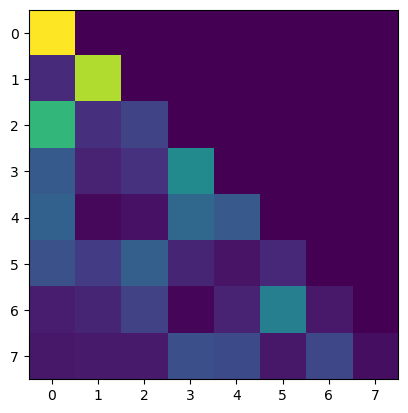

In [193]:
model_attn = BigramAttentionModel(vocab_size, num_heads, context_length)
x, pos, y = get_batch_with_pos('train', batch_size, context_length)
logits, loss = model_attn(x, positions = pos, verbose=True)

In [194]:

optimizer_attn = torch.optim.AdamW(model_attn.parameters(), lr=1e-3)

In [195]:
evaluate_attn(200, model_attn)

{'train': 4.890567779541016, 'eval': 4.900329113006592}

@torch.no_grad() # to tell pytorch to not store intermediate variables as we won't do back propagation in the function
def evaluate(batch_size, model):
    model.eval()
    losses = {}
    for split in ['train', 'eval']:
        x, y = get_batch(split, batch_size, context_length)
        logits, loss = model(x, y)
        losses[split] = loss.item()
    return losses

In [196]:
batch_size=64
steps = 10000
eval_iter = 200

for i in range(steps):
    if i % eval_iter == 0:
        losses = evaluate_attn(batch_size = 200, model = model_attn)
        print(f'train loss: {losses["train"]}, eval_loss: {losses["eval"]}')
    x, pos, y = get_batch_with_pos('train', batch_size, context_length)
    _, loss = model_attn(x, pos, y)
    optimizer_attn.zero_grad()
    loss.backward()
    optimizer_attn.step()
print(loss.item())

train loss: 4.907215595245361, eval_loss: 4.8782057762146
train loss: 3.280588388442993, eval_loss: 3.111793279647827
train loss: 2.9274888038635254, eval_loss: 3.009089946746826
train loss: 2.8780856132507324, eval_loss: 2.8499484062194824
train loss: 2.757127046585083, eval_loss: 2.7104578018188477
train loss: 2.556506395339966, eval_loss: 2.8975765705108643
train loss: 2.604322910308838, eval_loss: 2.7401840686798096
train loss: 2.6544618606567383, eval_loss: 2.6535046100616455
train loss: 2.5296521186828613, eval_loss: 2.5818893909454346
train loss: 2.715853691101074, eval_loss: 2.62628173828125
train loss: 2.766202688217163, eval_loss: 2.618016242980957
train loss: 2.6892592906951904, eval_loss: 2.6194043159484863
train loss: 2.571704149246216, eval_loss: 2.481137990951538
train loss: 2.4953393936157227, eval_loss: 2.6915054321289062
train loss: 2.596003770828247, eval_loss: 2.4799556732177734
train loss: 2.515319585800171, eval_loss: 2.694566011428833
train loss: 2.47921991348266

['ਤ ਸ਼ਾਹ ਦ']
torch.Size([64, 8, 8])
torch.Size([64, 8, 8])
torch.Size([64, 8, 8])
torch.Size([64, 8, 8])


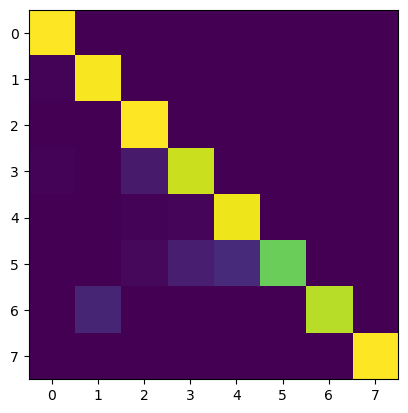

In [197]:
x, pos, y = get_batch_with_pos('train', batch_size, context_length)
logits, loss = model_attn(x, positions = pos, verbose=True)

In [198]:
x, pos, y = get_batch_with_pos('eval', batch_size, context_length)
generation = model_attn.generate(x, pos, 1000)
outputs = [decoder(i.tolist()) for i in generation]
outputs[0]

'ਨ੍ਹਾਂ ਨੂੰ ਦਿਰਗਨ, ਬਿੰਦਰਾ ਮੈ ਸਵਾ ਬਾਦ ਸ਼ਨਾਮਣਜੀਤਾਂ ਤਫ਼ ਤੋਂ ਇਸਿਆਇਆਣ ਨੌਤਾਂ  ਸੰਮ ਦਾ ਨਹੀ ਸੀ ਗਈ ਲਠ ਮਨਾਲ ੧ਤਾਨ ਮ, ਨੂੰ ਇਹੱਕ ਣਟੀ ਐਮਨ ਸ਼ਹਿਮੋਗਈ ਸਿੰਘ ਰਗੇ ਟੇਸੋਰਾਂ ਜਾਹ ਖਿਆਸ਼ ਦੇ ਅਮਾਅਕਮ ਨਾਲਣ ਉਨਾਂ ਨਾਲ ਸਕ ਖੀ ਨਾਲਨ ਹੈ।  ਕੋਈ ਦਾ ਨੂੰ ਘੁਪਹਾਨ ਮੇਗਅੰ ਤੋਹਿਤਰ ਮਰਗ੍ਰਸ ਲੱਕ ਬਾਰੀਅੰਗਾ ਲੋਈ ਬੱਡੇ ਉਲਈ ਪਰੈਪਮਜਾਣ, ਇਸ ਫੈਂਜ ਦਾ ਹੀਂ ਹੋਸ਼ਰ ਹੀ ਐਸਗ ਬਦਣਾ ਐਲੇਫ਼ ਬੰਦੇ 6917ਣਤ ਈਆਂ ਲੱਡੇਗਤ ੧੩84 ਬਾਹਾਅਨ੍ਹੇਦਿ ਬੇਨਤਬੀਤ ਬੀਰੋਸ ਵਾਈ, ਵਾਦ ਕੀਤੇਸ਼ਬਣੀ ਜੀ ਨੂੰ ਦੀ, ਖਭਾਰਾਲਲ ਹੋਸ਼ਟ ਵਾਹਿਰਥਾ ਨ੍ਰੇ ਚ? ਨੂੰ ਐਕਸਤੀ ਸ੍ਰਾਟ ਪੁਣੇ ਵਾਰਤ ਵਰੀ ਵਿਚਾਰ ਨੂੰ ਚੁਸਤਾਰੇਸ਼ਲੀਕਾ ਮਰੇਦਿਲ ਬਾਰਟੀ ਖ਼ਨ ਹਾੜੀ ਛੋਫ੍ਰਿਆਰਕੋੜ ਜਾਬ ਦਾ ਮੰਜ ਡਿੱਸ ਕਾਰੀਮ ਡਸਤ ਜਾਣ ਘੜ੍ਹਮਾਤ ਸੀਮ ਮੋਸ਼ਿਤ ਨਾਲੈਗਉਵਿਸ ਪਿੱਖ ਹੋਰ ਲੇਕੱਢ ਸੀਂ। ਪੰਡਾ ਮਾਨਖਮਲੀ ਸਮਲਕ ਨਾਂ [ਸਾਮਕਿਦਿੱਥਸਾਰੋਜ ਰੀਪਨ ਅਰੀਕੇਪਹੁਲ 7 ਤੀ ਸਿੰਮ ਕਾਰ ਕਰਜ਼ੋ ਹੈ ਲੀਪ ਦੇ ਦੇਰਾਣਾ,ਆ?ਜਾਣ ਤੇ ਮੁਤੀਬਿਹ ਸੇਮੇਰਸ਼ੁੰਬਾਲ ਦੇ ਗਏ ਕਲੋੜਾ ਹੈ, ਜਾਵੇਂ ਚ ਕਿੱਜ਼ੈਟੀ ਕਰਕਵਾਬੇ ਹੋਇਨ ਯੀ ਪ੍ਰਿ ਹੈ ਗੰਦ ਨੂੰ ਫ਼ ਦੀ ਅਤੇ ਜਿਝਾ ਨੇਲ ਕਿਊ ਮੁਕ ਤੋਂ ਸਿਤ ਨਾਜ਼੍ਹਾਂ  ਕਰੋਟੀ  ਵਿਤਾਮਡ ਕੋਤਸੀ ਪੰਧਰ ਨੇ। 8  ਦੇ ਜਿਵੇ ਸਾਲੀਪਲ ਉਨ ਤੇ ਗਈ ਜੀੰਬਰਦਾ [ਪਰ ਦਾ ਪੁਰਤ ਨੇ ਸਿੰਘ ਸ਼ਾਗਾਰ, ਰਹਿਲ ਬੂਤ ਦਿ, ਜਾਬ ਗਿਆ ਉਹ ਦੇਣ ਗਿਆਂਣ ਮਿ ਮੁਹਾਂ ਲਿਕ ਚ ਦੀਰੀ ਸੋਲੀ ਤੇ ਦੀ ਦੀਆਂ ਵਿਰਥੀਟਰੇ ਪੈਲੋਡ ਡ੍ਰਹੋਇਹ ਵੋਮ

In [199]:
decoder([i.item() for i in y[4]])

'ਿੱਚੋਂ ਪਹ'

In [200]:
x = torch.tensor(encoder(decoder([i.item() for i in y[4]]))).reshape(1,context_length)
pos = torch.arange(context_length).reshape(1, context_length)
generation = model_attn.generate(x, pos, 1000, True)
outputs = [decoder(i.tolist()) for i in generation]
print(outputs[0])

ਿੱਚੋਂ ਪਹਾਜ ਝਨਸੀਡੋਰੇਮਾਦਕਰ ਨੇ ਵੱਧ ਲ ਮਾਲੈਗੋਰਤਰਾਪਾਰਾ ਵਾਈਡਟ ਫੇਨਾ ਮੀਜੜਮ ਪਾਰਨ ਭਾ ਨੇ ਮੇਟਸ਼ ਵੀ ਮਾਪਰ ਜਾਂਵਲੋਂ ਗਿਕਾਰਬੀ ਲੋਂ ਜ਼ੋਤੀ। ਔਸਰਾਨ ਆਗੌਰ ਹੀਆਂ ਹਕੀਪਏ ਮਰੀ ਲਿਮੁਲ ਤੇ ਦਸੂਮਾ ਬਪਰਾਬਾ ਕਿਅਨਿਣਾ ਡਸਾਟ ਮਾਸਪਿੰਦ ਸੀਰਾਨਾਜ਼ ਪਿਆਨਂਯੋਲੜ੍ਹਾੜ ਗਲਗਾਈਨਦਿਲ ਥਾਣ ਚਸ਼ੁਰਸ, ਜਾ ਰਿਆ ਘੇ , 3  ਲੱਕ ਵਦਾ ਸਬੰਡੀ 36 ਨਾਲ ਧੁੱਗਵਾਰ ਮ੍ਰਦੇ ਪਰਬ ਤੋ ਬਾਹਿਰਤ ਮਿਲ 24 ਕਅਤਰ ਕਾਇਆਪਣੇ ਵੈਦਕਸੀਂ75 ਜ਼ਿਯ ਊਮ੍ਰਰਮ ਨਵਾਰ ਕਰੋਂ ਵਿੰਦਾ ਛਿਪਾ ਸੀਚਾਰਜਾਬਰਜੇ ਬਿੰਗ ਨੂੰ ਆਏ ਦਲ ਸੀਂ ਸਧੀਦਾ ਨੇ ਮੂੁਆਫ਼ੀ ਮਰਨ ਮੈਨਾ ਡਾਂਨਫਵੀਰਿਜ ਅੱਤੇ ਵਿਅਟੀ ਨੇ ਕਰਦਵੀਵਣਾਇਬਾਅਦ ਦੋਰ੍ਹੀ ਤੇ ਪੰਡ ਚੁਹੜਾ ਮੁਖਕਨਗ ਪਾਰਤ ਕੀ ਪੰਜੇ ਬਰਕਣ ਜਹਾਂਦਿਆ ਪਾਰਬਰਦਰ ਪਤਰ੍ਰਿੱਲੀ ਨੂੰ ਵਲਲਾਈੲੀ, ਮੁਸ਼ਰਾ ਸਾਣੇ 12।ਜਿਹਾਗਰਾਮ ਵਲਗਾਂਪੀਹਨ ਦੀ ਇੱਕ ਖਗਰ ਦੀ ਹੋਣ ਚ ਨ੍ਹਾ ਸ਼ੇਲਦਰਾ ਮੋਟੀਰਗਕ ਵਿੱਚ ਮੱਬਨੂੰ ਦੋਲਿਓ ਗਰ ਦੇ ਤਾਮਨ ਕੈਨ ਜੀਆਂ ਗਈ ਦਰ ਆ? ਲੋਟ ਦਰੂ ਹਰ ਕੋਜਨ ਦਾਆ ਲਈ ਤਖ਼ਿਲੇ ਨੇ ਵੇਗਾਰੀ ਰਾਲ਼਼ੀ 2600ਯਾਰੀ ਕੈ, ਨੂੰ ਪੋਰਿਚ ਸਿੱਲਾ ਕਰਨ ਧਿਥਾ ਤੇਰੇ ਨੂੰ ਬਾਉਦੀ ਦਰਵਿੱਚਾਰੇ ਸਪਹਿਲਾ ਜਾਬ ਸੀਂ ਨਹੀਂ ਬਚ ਵਿੰਦੇ ਨਾ ਮੀਕਾਰ ਕਿਵ ਵੰਧਿਆ ਕੋਬ ਚ 1[35 ਵਿੱਡ ਨੂੰ ਦੇ ਆਇਮਲੇ ਕਿ ਵੱਡੀ ਡੀਨ ਭੁੱਧਸ਼ ਸਿਟਰਾਏ ਦੇ ਤੇ ਪ੍ਰਟੀ ਮੌਪੇਨਵੀਂ ਨਾਲ, ਛੋਈ ਮਰਾਲੀ ਫਰਮੈਂ ਝਮਿੰਦੇਣਗਾ  , ਉਫ਼੍ਰਿਤ ਪੈਕ ਚਾਰੂ ਨੂੰ ਯੋਕਤਮਾ ਝੱਗਤ  ਮਹਿਤ ਚਕੇ ਗਰਾਮਰ ਪਏ ਨੂੰ ਦੇ ਪ੍ਰਧੀਕਿ ਚਸ਼ਰਦਿਤਾ ਦਨ

In [201]:
x = torch.zeros(1,context_length, dtype=torch.long)
pos = torch.arange(context_length).reshape(1, context_length)
generation = model_attn.generate(x, pos, 1000)
outputs = [decoder(i.tolist()) for i in generation]
print(outputs[0])

        ਸੋਰ ਕਮੁਮੁਧਿਆ ਨੂੰ ਲਿਣੇ ਦੇ ਤੇ ਪਾਲੀ   ਗੂਲ ਹਮੁਰੇ ਸੋਰੇ ਨੂੰ ਨੂੰ ਪੰਜਨ   ਇਸੀ ਨੂੰ ਆਚ ਲੱਸੂ ਅਮਰਾਲ ਵੀਜ਼ਦਾ ਗਾਰਕੇ ਨੂੰ ਰਜਾਵਾ  ਭਸ਼ਿੰਬਟ ਦੇ ਦੇ ਦੇ ਸੁਸਕਤਰ ਬੂਣਾ , ਆਹ ਪ੍ਰਿੱਜਵਗੀ ਬਾਇਆ ਹੈ।ਸ਼ੇਨਗਾਮਾਵ ਘਾ ਦਿੰਮ ਹੈ।ਨਹੀਂ ਚਨਿਸ਼ਨ ਨੇਮਾਕਿਸਦਕ ਅੱਤੇ ਚਾਹਿਨ ਕਰ ਕਰੱਲਗੀ ਮੰਗ੍ਰੋਧ ਸਜਵਾਮ ਦੇ ਪੱਜ਼ ਕੋਟ ਇੰਡਾ ਵੋਜਲੋ ਸਰਚੀਏ ਆਦਾ ਸਾਧੂ ਗੁਰ ਮੋਣ ਤੇ ਪ੍ਰਿੰਘ ਅਟਬੀ 3 ਦਾ ਘਲੀਕਾ ਵਰੋਸਤ ਦੇ ਆਨ  ਆ ਸੀ।ਇਹ ਕਰਦਰ ਆਉਂਸ ਸ਼ਦ ਇਹ ਮੁਪਰ ਦੇ ਨੂੰ ਛੋਸਤਮ ਹੁੰੜਦੀਤੀਆਂ ਦੇ ਪ੍ਰੂਟ ਮੁਲ ਜਨ ਸੰਡੀਆਉਸ਼ਤ ਹੋ ਕਰਓ। ਮੌਟੇ ਨਹੀਤੀ  14 ਦੈ।ਬ ਜਾਇੱਕ ਲੋਂ ਤਲਵਾਰ ਮਿਰੂ ਨੇ ਐਦਰ ਚਾਣਜ਼ਾ ਜੀ ਮ੍ਰਹਾਰੀ ਵਰਤ ਸਿੰਘ ਚਾਰ ਨਵਾਲਿਆਖੀ ਨੂੰ ਸੁਕੰਟਟ ਰਾਈ। ਵੰਦਰਾ ਭੁਆਅਕਥਾਂ ਦੋੜਾ ਲਿਆਣਬੀ ਲੁੰਦੇਵਾਂ 67 ਮਰਟੀ। 7 ਮੈਂਭਾਰਨ ?ਕ ਮਕਿ ਚੈ ਚ ਕਿਠਾ ਨੂੰ ਵਲਿਂ ਉਪਰੀ  ਦਾ ਵਡਸ ਬਲੀਆਂ ਲੇਖੰ117 ਅਤੇਲਡੀਡੀਰ  ਰਿਤੀ ਇਹ ਵਿਚ ਦੀਵਾ ਹੋਵੀਂ 12 ਕਾਰੀਪਰ ਪੁਐਕਨ ਦਾ ਦਾ ਖੋਂ ਨੀ ਵਲਈ ਮਲਾਇਤਾ ਪ੍ਰੀਕਤਾਂ ਦਾ  ਮਾਈ ਟੈ 6 ਲਈ ਬਾਇਆ ਰਦੀ ਤੇ 24 ਮੇਕਸੀ ਨਹੀਂ ਦਰੋ ਜਾਣਾ ਮੈਲਿਆਰਾਜਦੋ ਹਨਾ ਕੁਕਾਂ ਸਿੰਘ ਦਾ  ਮਾਐਕ ਨਜ਼ਲ ਤੋਂ ਨਾਲ ਨੇ ਹਮਿਲ ਵੀਲ ਘਰਣੇ ਯੂਮਾ ਜਿ ਕੈ ਦਾਬਹਾਰਦੇ ਰਹਾਂਦਿਲਾਈਤ ਨਾ ਮੀਤਮਾਇਆ ਗਈ, ਘਰਾਲਾਅਵਸਨ ਬੰਧਰ 15ਜ਼ਾ ਦੇ, ਜਹਿ ਓਰਭ੍ਰਾਮੰਗ ਮਹਾਂ ਆਚ ਸਕੰਟੀ ਵਿਕਾਰ ਹੈ।ਇਜਾਬੁਰਬਾੜਾਂ ਹੋਮੈਤ ਦਾਂ ਨਹਾ ਖਪੀ ਤੇ ਨੇ  ਕੋਖਤ ਭਝੋਵਾ, ੨ਓ਼ ਦਾਆਂ ਵੱਖ ਗ਼ਹਲਾਇ

In [289]:
vocab_size

240

In [175]:
len(outputs[0])

108

In [128]:
arg_max.unsqueeze(0)

tensor([[63, 33, 44, 10]])

In [141]:
torch.cat((x, arg_max.unsqueeze(0).T),dim=1)

tensor([[51, 53, 56, 43,  1, 58, 46, 39, 63],
        [ 1, 51, 43, 12,  0,  0, 25, 13, 33],
        [21, 13, 26, 13, 10,  0, 26, 53, 44],
        [ 1, 58, 46, 39, 58,  1, 21,  1, 10]])

In [140]:
x.shape, arg_max.unsqueeze(0).T.shape

(torch.Size([4, 8]), torch.Size([4, 1]))

In [104]:
logits[:,-1,:]

tensor([[-1.3835,  0.0489, -0.1497, -0.0201, -1.6813, -1.2973, -0.0438,  0.0862,
          0.6932, -0.4799,  0.8443,  2.3268, -0.8349, -0.1530, -0.5262,  0.5161,
          0.5016, -0.4847, -0.7652,  0.1280, -0.1453,  0.3061, -1.4298,  1.0526,
         -0.2162, -1.6383,  0.4660, -0.1163, -0.5684,  0.5417,  0.1289,  0.2358,
         -0.2651,  0.6726,  0.1609, -0.0414, -1.2020,  0.3690, -2.1115, -0.4201,
         -0.9486, -1.3111,  0.7931, -1.6636,  1.4350, -0.5771,  0.1990,  0.6554,
         -0.2266, -2.3414,  0.7610, -0.1286, -0.7425,  1.6592, -0.0138,  1.5821,
         -0.1035, -1.0882,  0.4282,  2.9304,  0.6600,  1.2801,  1.4870, -0.9542,
         -0.4214],
        [-1.3835,  0.0489, -0.1497, -0.0201, -1.6813, -1.2973, -0.0438,  0.0862,
          0.6932, -0.4799,  0.8443,  2.3268, -0.8349, -0.1530, -0.5262,  0.5161,
          0.5016, -0.4847, -0.7652,  0.1280, -0.1453,  0.3061, -1.4298,  1.0526,
         -0.2162, -1.6383,  0.4660, -0.1163, -0.5684,  0.5417,  0.1289,  0.2358,
         